# H<sup>-</sup> bound-free/free-free opacity

This tutorial shows how to create H<sup>-</sup> opacity objects and compute their extinction coefficient spectra for a given atmospheric profile.

This model computes the H- free-free and bound-free cross sections (cm$^5$ H$^{-1}$ electron$^{-1}$) based on Eqs. (6) and (4) of [John (1988)](https://ui.adsabs.harvard.edu/abs/1988A%26A...193..189J):

$$ 
\begin{array}{ll}
\kappa_{\lambda}^{\rm ff}(T) = 10^{-29} k_{\rm B} T \sum_{n=1}^6 \left(\frac{5040}{T}\right)^{(n+1)/2}
\{A_n \lambda^2 + B_n + C_n \lambda^{-1} + + D_n \lambda^{-2} + E_n \lambda^{-3} + F_n \lambda^{-4}\} \\
\\
\kappa_{\lambda}^{\rm bf}(T) =  0.75 k_{\rm B} T^{-3/2}\ \exp(\alpha/\lambda_0 T)\ [1-\exp(-\alpha/\lambda T)]\ \sigma_0
\end{array}
$$

<div class="alert alert-info">

Note

You can also find this tutorial as a [Python script here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_h_ion.py) or as a [jupyter notebook here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_h_ion.ipynb).

</div>


In [1]:
#  Lets start by importing some useful modules
import pyratbay.opacity as op
import pyratbay.atmosphere as pa
import pyratbay.constants as pc
import pyratbay.spectrum as ps

import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Wavelength array (microns) where to sample the opacities
wl_min = 0.3
wl_max = 15.0
resolution = 15000.0
wl = ps.constant_resolution_spectrum(wl_min, wl_max, resolution)
# as wavenumber (in cm^-1 units)
wn = 1.0/(wl*pc.um)

# Initialize H- opacity model:
h_ion = op.Hydrogen_Ion(wn)


In [2]:
# A print() call shows some useful info about the object:
print(h_ion)
# TBD

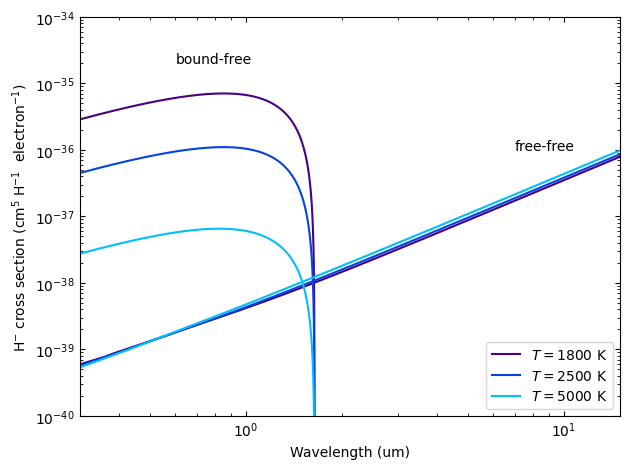

In [3]:
# Compute H- cross sections at 3 temperatures:

temps = [1800.0, 2500.0, 5000.0]
ntemps = len(temps)
cs_bf = np.zeros((ntemps,h_ion.nwave))
cs_ff = np.zeros((ntemps,h_ion.nwave))
for j in range(ntemps):
    cs_bf[j] = h_ion.cross_section_bound_free(temps[j])
    cs_ff[j] = h_ion.cross_section_free_free(temps[j])

# Note that the temperature argument can also be a 1D iterable, e.g.,
# to evaluate the cross sections over an entire atmospheric profile


# Plot the cross sections:
cols = ['indigo', 'xkcd:blue', 'deepskyblue']

plt.figure(1)
plt.clf()
ax = plt.subplot(111)
for j in range(ntemps):
    plt.plot(wl, cs_bf[j], color=cols[j], label=f'$T = {temps[j]:.0f}$ K')
    plt.plot(wl, cs_ff[j], color=cols[j])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(which='both', right=True, top=True, direction='in')
ax.legend(loc='lower right')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('H$^{-}$ cross section (cm$^5$ H$^{-1}$  electron$^{-1}$)')
ax.text(0.6, 2e-35, 'bound-free')
ax.text(7.0, 1e-36, 'free-free')
ax.set_xlim(0.3, 15.0)
ax.set_ylim(1e-40, 1.0e-34)
plt.tight_layout()

## Extinction coefficient


Compute chemical abundances.


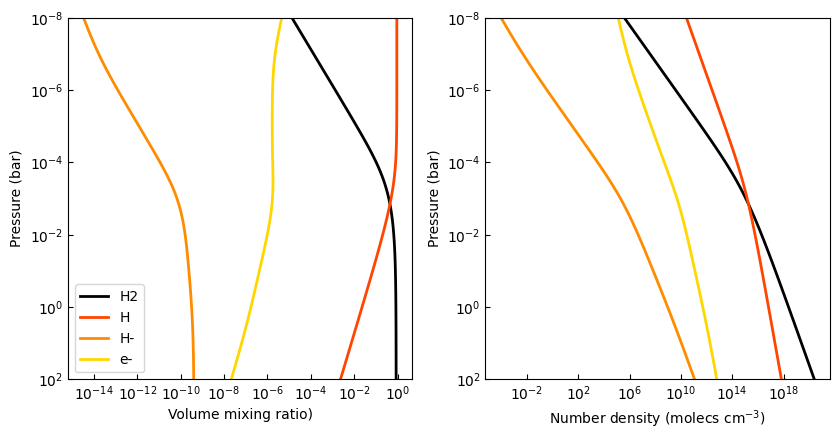

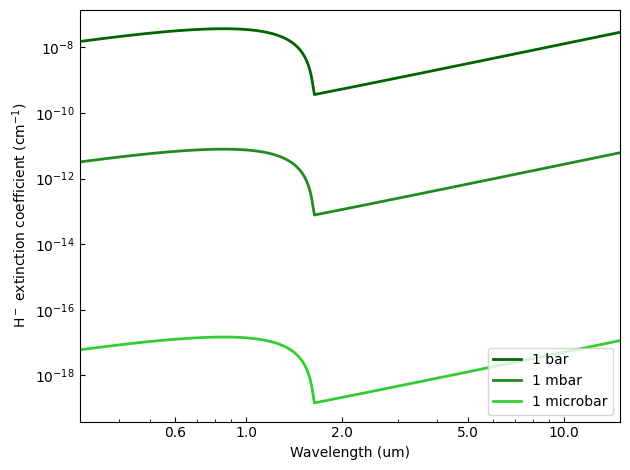

In [4]:
# Likewise, we can calculate extinction coefficient by providing a
# temperature and number density profile:

# Consider a solar-abundance isothermal atmosphere
nlayers = 81
pressure = pa.pressure('1e-8 bar', '1e2 bar', nlayers)
temperature = np.tile(2500.0, nlayers)

# Get VMRs in thermochemical equilibrium for a simple mix of species
# and their number-density profiles under IGL (molecules per cm3)
species = ['H2', 'H', 'He', 'H-', 'H+', 'Na', 'Na+', 'K', 'K+', 'Si', 'Si+', 'e-']
chemistry = pa.chemistry('tea', pressure, temperature, species)
number_densities = pa.ideal_gas_density(chemistry.vmr, pressure, temperature)

imol = [species.index(mol) for mol in ['H', 'e-']]
density = number_densities[:,imol]

# Total H- extinction coefficient (cm-1)
ec = h_ion.calc_extinction_coefficient(temperature, number_densities[:,imol])


# Show profiles:
cols = {
    'H2': 'black',
    'H': 'orangered',
    'H-': 'darkorange',
    'e-': 'gold',
}
plt.figure(11, (8.5, 4.5))
plt.clf()
ax = plt.subplot(121)
for spec, col in cols.items():
    i = species.index(spec)
    ax.plot(chemistry.vmr[:,i], pressure, color=col, lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(100, 1e-8)
ax.tick_params(which='both', direction='in')
ax.set_xlabel('Volume mixing ratio)')
ax.set_ylabel('Pressure (bar)')
ax.legend(loc='best')

ax = plt.subplot(122)
for spec, col in cols.items():
    i = species.index(spec)
    ax.plot(number_densities[:,i], pressure, color=col, lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(100, 1e-8)
ax.tick_params(which='both', direction='in')
ax.set_xlabel('Number density (molecs cm$^{-3}$)')
ax.set_ylabel('Pressure (bar)')
plt.tight_layout()


plt.figure(12)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, ec[64], color='darkgreen', lw=2.0, label='1 bar')
ax.plot(wl, ec[40], color='forestgreen', lw=2.0, label='1 mbar')
ax.plot(wl, ec[16], color='limegreen', lw=2.0, label='1 microbar')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('H$^-$ extinction coefficient (cm$^{-1}$)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.6, 1.0, 2.0, 5.0, 10.0])
ax.set_xlim(0.3, 15.0)
ax.tick_params(which='both', direction='in')
ax.legend(loc='lower right')
plt.tight_layout()